# A composite electrode particle model

 A composite electrode particle model is developed for (negative) electrodes with two phases, e.g. graphite/silicon in LG M50 battery cells. The current version is demonstrated for negative composite electrodes only but is easily extended to positive composite electrodes. The reference is at the end of this notebook.

## How to use the model

Let us set up PyBaMM 

In [30]:
# %pip install "pybamm[plot,cite]" -q    # install PyBaMM if it is not installed
import os
import timeit

import matplotlib.pyplot as plt
from matplotlib import style

import pybamm

style.use("ggplot")
os.chdir(pybamm.__path__[0] + "/..")

Choose the option `{"particle phases": ("2", "1")}` to load the composite electrode particle model by specifying that there are two particle phases (graphite and silicon) in the negative electrode. The parameter set "Chen2020_composite" includes parameters for silicon as a secondary particle

In [31]:
start = timeit.default_timer()
model = pybamm.lithium_ion.DFN(
    {
        "particle phases": ("2", "1"),
        "open-circuit potential": (("single", "current sigmoid"), "single"),
    }
)
param = pybamm.ParameterValues("Chen2020_composite")

param.update({"Upper voltage cut-off [V]": 4.5})
param.update({"Lower voltage cut-off [V]": 2.5})

param.update(
    {
        "Primary: Maximum concentration in negative electrode [mol.m-3]": 28700,
        "Primary: Initial concentration in negative electrode [mol.m-3]": 23000,
        "Primary: Negative particle diffusivity [m2.s-1]": 5.5e-14,
        "Secondary: Negative particle diffusivity [m2.s-1]": 1.67e-14,
        "Secondary: Initial concentration in negative electrode [mol.m-3]": 277000,
        "Secondary: Maximum concentration in negative electrode [mol.m-3]": 278000,
    }
)

## Single Cycle Simulations

Define a current loading

In [32]:
C_rate = 0.5
capacity = param["Nominal cell capacity [A.h]"]
I_load = C_rate * capacity

t_eval = [0, 10000]

param["Current function [A]"] = I_load

It is very easy to vary the relative volume fraction of each phase. The following example shows how to compare the results of batteries with three relative volume fractions (0.001, 0.04, 0.1) of silicon.

In [33]:
v_si = [0.001, 0.04, 0.1]
total_am_volume_fraction = 0.75
solution = []
for v in v_si:
    param.update(
        {
            "Primary: Negative electrode active material volume fraction": (1 - v)
            * total_am_volume_fraction,  # primary
            "Secondary: Negative electrode active material volume fraction": v
            * total_am_volume_fraction,
        }
    )
    print(v)
    sim = pybamm.Simulation(
        model,
        parameter_values=param,
    )
    solution.append(sim.solve(t_eval=t_eval))
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

0.001
0.04
0.1
running time: 0.8212654160161037s


## Results
Compare the cell voltages of the three cells in this example, to see how silicon affects the output capacity

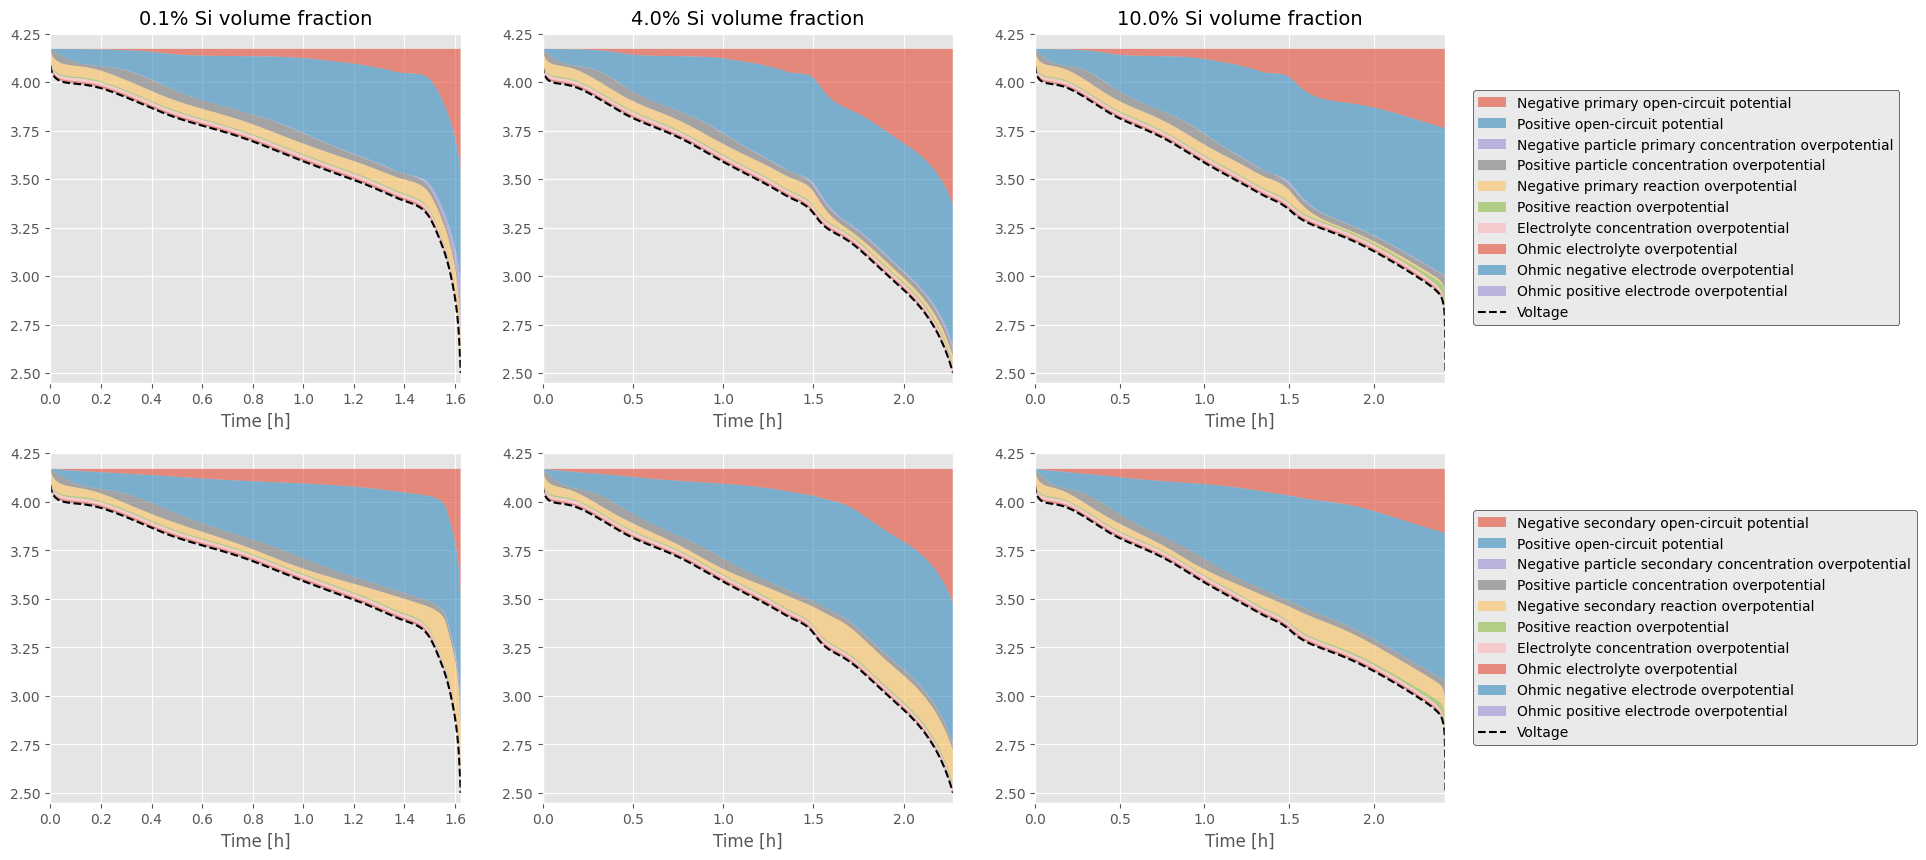

In [34]:
fig, axs = plt.subplots(2, 3, figsize=(18, 10))

for i, v in enumerate(v_si):
    solution[i].plot_voltage_components(
        ax=axs[0, i],
        split_by_electrode=True,
        electrode_phases=("primary", "primary"),
        show_plot=False,
        show_legend=(i == 2),
    )
    solution[i].plot_voltage_components(
        ax=axs[1, i],
        split_by_electrode=True,
        electrode_phases=("secondary", "primary"),
        show_plot=False,
        show_legend=(i == 2),
    )
    axs[0, i].set_title(f"{v * 100:.1f}% Si volume fraction", fontsize=14)

plt.show()

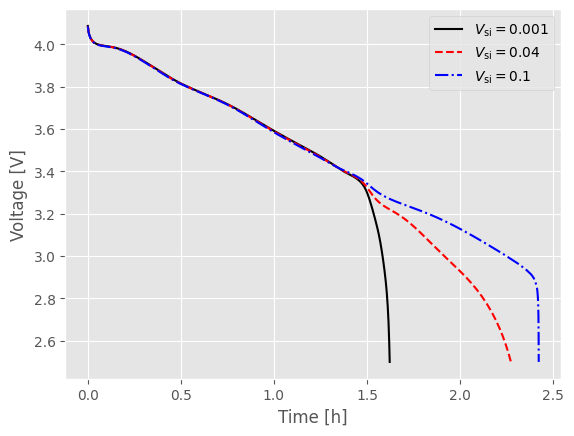

In [35]:
ltype = ["k-", "r--", "b-.", "g:", "m-", "c--", "y-."]
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    V_i = solution[i]["Voltage [V]"].entries
    plt.plot(t_i, V_i, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Voltage [V]")
plt.legend()

Results of interfacial current density in silicon

Text(0.5, 1.0, 'Silicon')

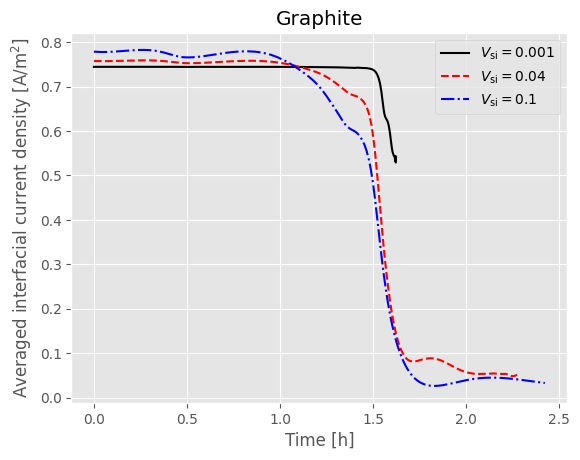

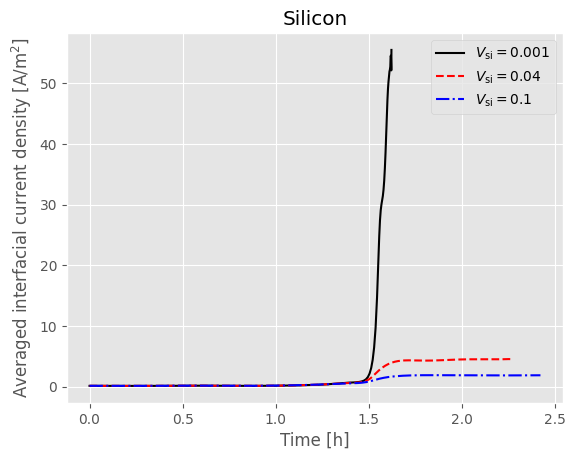

In [36]:
plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p1_av = solution[i][
        "X-averaged negative electrode primary interfacial current density [A.m-2]"
    ].entries
    plt.plot(t_i, j_n_p1_av, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Averaged interfacial current density [A/m$^{2}$]")
plt.legend()
plt.title("Graphite")

plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p2_av = solution[i][
        "X-averaged negative electrode secondary interfacial current density [A.m-2]"
    ].entries
    plt.plot(t_i, j_n_p2_av, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Averaged interfacial current density [A/m$^{2}$]")
plt.legend()
plt.title("Silicon")

Results of interfacial current density in graphite

Text(0.5, 1.0, 'Silicon')

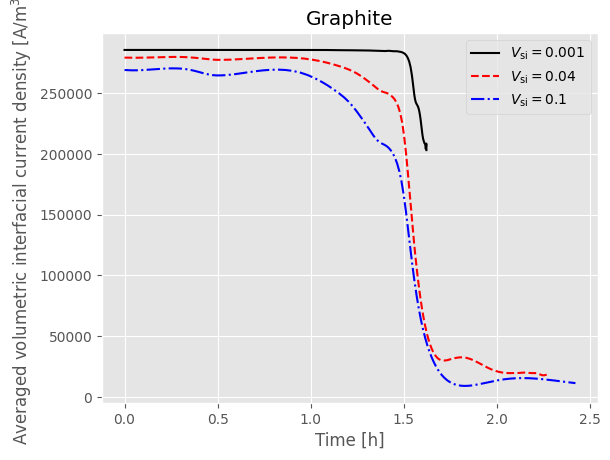

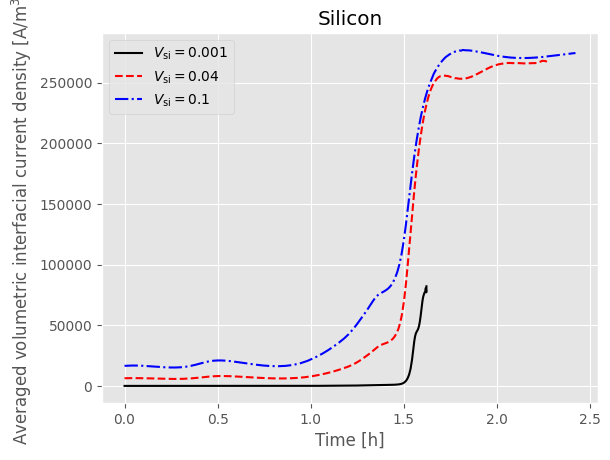

In [37]:
plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p1_Vav = solution[i][
        "X-averaged negative electrode primary volumetric interfacial current density [A.m-3]"
    ].entries
    plt.plot(t_i, j_n_p1_Vav, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Averaged volumetric interfacial current density [A/m$^{3}$]")
plt.legend()
plt.title("Graphite")

plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    j_n_p2_Vav = solution[i][
        "X-averaged negative electrode secondary volumetric interfacial current density [A.m-3]"
    ].entries
    plt.plot(t_i, j_n_p2_Vav, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Averaged volumetric interfacial current density [A/m$^{3}$]")
plt.legend()
plt.title("Silicon")

Results of average lithium concentration

Text(0.5, 1.0, 'Silicon')

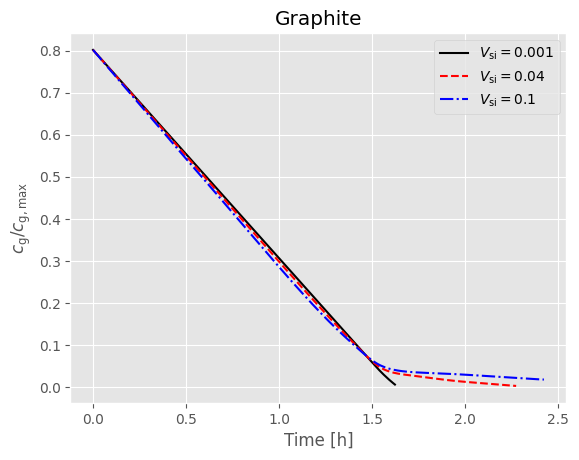

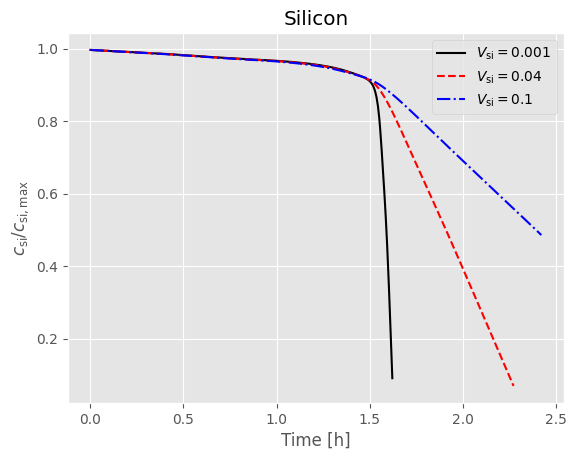

In [38]:
plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p1 = solution[i][
        "Average negative primary particle concentration"
    ].entries
    plt.plot(t_i, c_s_xrav_n_p1, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("$c_\mathrm{g}/c_\mathrm{g,max}$")
plt.legend()
plt.title("Graphite")

plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    c_s_xrav_n_p2 = solution[i][
        "Average negative secondary particle concentration"
    ].entries
    plt.plot(t_i, c_s_xrav_n_p2, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("$c_\mathrm{si}/c_\mathrm{si,max}$")
plt.legend()
plt.title("Silicon")

Results of equilibrium potential

Text(0.5, 1.0, 'NMC811')

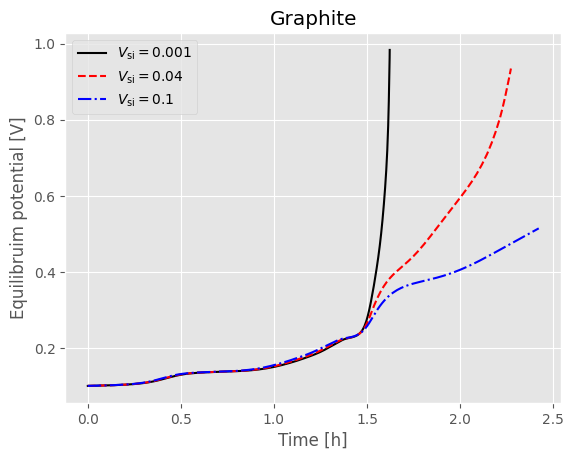

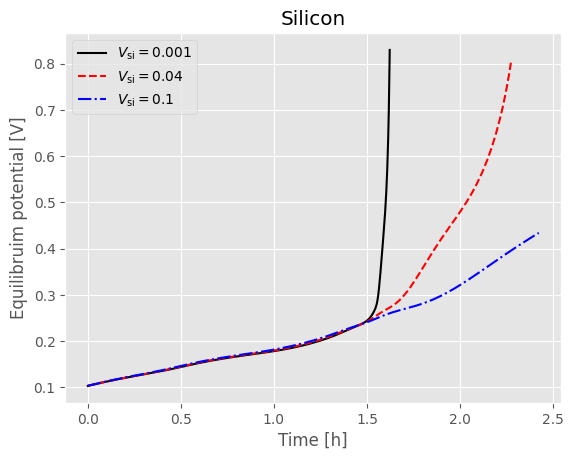

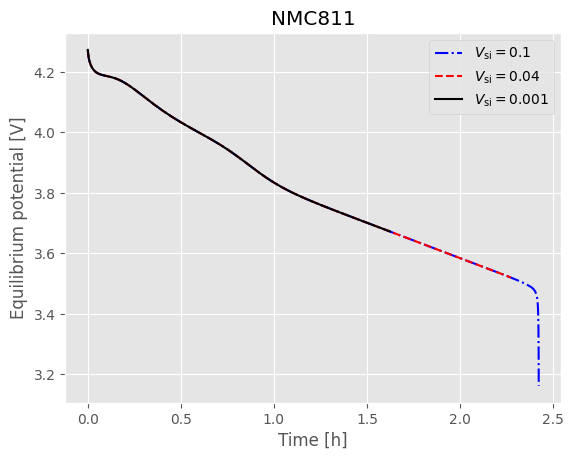

In [39]:
plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p1 = solution[i][
        "X-averaged negative electrode primary open-circuit potential [V]"
    ].entries
    plt.plot(t_i, ocp_p1, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title("Graphite")

plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    ocp_p2 = solution[i][
        "X-averaged negative electrode secondary open-circuit potential [V]"
    ].entries
    plt.plot(t_i, ocp_p2, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Equilibruim potential [V]")
plt.legend()
plt.title("Silicon")

plt.figure()
for i in range(0, len(v_si)):
    t_i = solution[len(v_si) - 1 - i]["Time [s]"].entries / 3600
    ocp_p = solution[len(v_si) - 1 - i][
        "X-averaged positive electrode open-circuit potential [V]"
    ].entries
    plt.plot(
        t_i,
        ocp_p,
        ltype[len(v_si) - 1 - i],
        label="$V_\mathrm{si}=$" + str(v_si[len(v_si) - 1 - i]),
    )
plt.xlabel("Time [h]")
plt.ylabel("Equilibrium potential [V]")
plt.legend()
plt.title("NMC811")

## Multi-Cycle Simulations
For multi-cycling, an experiment definition for static C/2 discharge and charge cycling is presented.

In [40]:
experiment = pybamm.Experiment(
    [
        (
            "Discharge at C/2 until 3.0 V",
            "Rest for 1 hour",
            "Charge at C/2 until 4.2 V",
            "Rest for 1 hour",
        ),
    ]
    * 2
)

The solution is reintroduced, with `calc_esoh=False` passed into the solve function. Currently, composite electrode state of health predictions are not included in this model. 

In [41]:
solution = []
for v in v_si:
    param.update(
        {
            "Primary: Negative electrode active material volume fraction": (1 - v)
            * total_am_volume_fraction,  # primary
            "Secondary: Negative electrode active material volume fraction": v
            * total_am_volume_fraction,
        }
    )
    print(v)
    sim = pybamm.Simulation(
        model,
        experiment=experiment,
        parameter_values=param,
    )
    solution.append(sim.solve(calc_esoh=False))
stop = timeit.default_timer()
print("running time: " + str(stop - start) + "s")

0.001
0.04
0.1
running time: 4.325905333011178s


## Cycling Results
The previously displayed single discharge results can be extended to the cycling solution. As an example, voltage is displayed below.

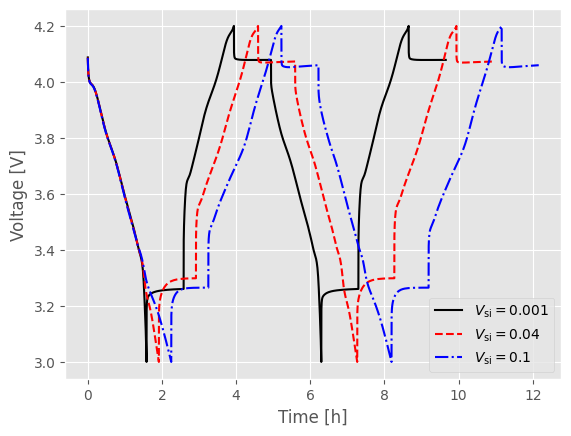

In [42]:
ltype = ["k-", "r--", "b-.", "g:", "m-", "c--", "y-."]
for i in range(0, len(v_si)):
    t_i = solution[i]["Time [s]"].entries / 3600
    V_i = solution[i]["Voltage [V]"].entries
    plt.plot(t_i, V_i, ltype[i], label="$V_\mathrm{si}=$" + str(v_si[i]))
plt.xlabel("Time [h]")
plt.ylabel("Voltage [V]")
plt.legend()

## References

The relevant papers for this notebook are:

In [43]:
pybamm.print_citations()

[1] Weilong Ai, Niall Kirkaldy, Yang Jiang, Gregory Offer, Huizhi Wang, and Billy Wu. A composite electrode model for lithium-ion batteries with silicon/graphite negative electrodes. Journal of Power Sources, 527:231142, 2022. URL: https://www.sciencedirect.com/science/article/pii/S0378775322001604, doi:https://doi.org/10.1016/j.jpowsour.2022.231142.
[2] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[3] Von DAG Bruggeman. Berechnung verschiedener physikalischer konstanten von heterogenen substanzen. i. dielektrizitätskonstanten und leitfähigkeiten der mischkörper aus isotropen substanzen. Annalen der physik, 416(7):636–664, 1935.
[4] Chang-Hui Chen, Ferran Brosa Planella, Kieran O'Regan, Dominika Gastol, W. Dhammika Widanage, and Emma Kendrick. Development of Experimental Techniques for